# Performace tests for HMC 

In [25]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp
import matplotlib.pyplot as plt
%matplotlib inline
from autograd import grad
import scipy.stats as st
import math

import time
from pyhmc import hmc

import pymc3 as pm

## BASIC HMC

In [16]:

def neg_log_normal(mu, sigma):
    """
    logp(x | mu, sigma) = 0.5 * log(2π) + log(σ) + 0.5 * ((x - μ)/σ)^2
    """

    def logp(x):
        return 0.5 * (np.log(2 * np.pi * sigma * sigma) + ((x - mu) / sigma) ** 2)

    return logp

def neg_log_mvnormal(mu, sigma):
    """Use a Cholesky decomposition for more careful work."""

    def logp(x):
        k = mu.shape[0]
        return (
            k * np.log(2 * np.pi)
            + np.log(np.linalg.det(sigma))
            + np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), x - mu)
        ) * 0.5

    return logp

In [17]:


#Leapfrog algorithm
def leapfrog(q,p,dVdq,path_len,step_size) :
    '''
    inputs :
    --------
    q,p (float)^D -> initial position and momentum
    dVdq (function)-> Gradient of velocity
    path_len (float) -> How long each integration path is
    step_size (float) -> How long each integration step shold be
    
    Outputs :
    ---------
    q,p -> new position and momentum
    '''
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p
    


#Hamiltonian Monte Carlo Technique 
def HMC(n_samples, negative_log_prob, initial_position, path_len=1, step_size = 0.1) :
    '''
    inputs :
    --------
    n_samples (int) -> Number of samples to return
    negative_log_prob (function) -> Negative log probability to sample from
    initial_position (np.array) -> Where we start sampling from
    path_len (float) -> How long each integration path is. Smaller is faster and more correlated.
    step_size (float) -> How long each integration step is. Smaller is slower and more accurate.
    
    Outputs :
    ---------
    An array of length n_samples
    ''' 

    dVdq = grad(negative_log_prob)
    
    samples = [initial_position]
    
    momentum = st.norm(0, 1)
    
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

## PYHMC

In [22]:
def logp_pyhmc(x, ivar):
    logp = -0.5 * np.sum(ivar * x**2)
    grad = -ivar * x
    return logp, grad

## PYMC3

### Speed comparison : evolution of time with dimension

In [52]:
N_sample = 1000
d_max = 10
times = [0 for i in range(d_max)]

for d in range(d_max) :
    D = 2**d
    
    #BASIC HMC
    logp_basic = neg_log_mvnormal(np.zeros(D),np.eye(D))
    x0_basic = np.random.randn(D)
    t_i_basic = time.time()
    samples_basic = HMC(N_sample,logp_basic,x0_basic)
    t_basic = time.time() - t_i_basic
    
    #PYHMC
    ivar = np.ones(D)
    x0_pyhmc=np.random.randn(D)
    t_i_pyhmc = time.time()
    samples_pyhmc = hmc(logp_pyhmc, x0=x0_pyhmc, args=(ivar,), n_samples=N_sample)
    t_pyhmc = time.time() - t_i_pyhmc

    #PYMC3
    with pm.Model() as multiNorm :
        x = pm.MvNormal('x', mu=np.zeros(D), cov=np.eye(D),shape=D)
    
    
    t_i_pymc3 = time.time()
    with multiNorm :
        samples_pymc3 = pm.sample(draws=N_sample, chains=1, init=None, step=pm.HamiltonianMC()).get_values('x')
    t_pymc3 = time.time() - t_i_pymc3
    
    times[d] = [t_basic,t_pyhmc,t_pymc3] 

Sequential sampling (1 chains in 1 job)
HamiltonianMC: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 1515.12it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1471.10it/s]
The acceptance probability does not match the target. It is 0.7583736591672959, but should be close to 0.65. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1446.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1282.03it/s]
Only one ch

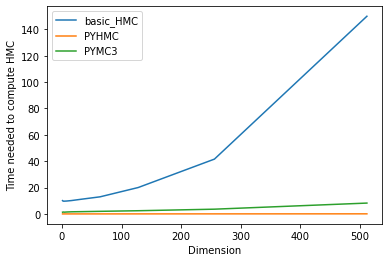

In [58]:
x = [2**d for d in range(d_max)]
ys = np.array(times)
plt.plot(x,ys[:,0],label='basic_HMC')
plt.plot(x,ys[:,1],label='PYHMC')
plt.plot(x,ys[:,2],label='PYMC3')
plt.xlabel('Dimension')
plt.ylabel('Time needed to compute HMC')
plt.legend()

### Speed comparison : evolution of time with Number of samples

In [55]:
D = 3
t_max = 5
times_NoS = [0 for i in range(t_max)]

for t in range(t_max) :
    T = 10**t
    
    #BASIC HMC
    logp_basic = neg_log_mvnormal(np.zeros(D),np.eye(D))
    x0_basic = np.random.randn(D)
    t_i_basic = time.time()
    samples_basic = HMC(T,logp_basic,x0_basic)
    t_basic = time.time() - t_i_basic
    
    #PYHMC
    ivar = np.ones(D)
    x0_pyhmc=np.random.randn(D)
    t_i_pyhmc = time.time()
    samples_pyhmc = hmc(logp_pyhmc, x0=x0_pyhmc, args=(ivar,), n_samples=T)
    t_pyhmc = time.time() - t_i_pyhmc

    #PYMC3
    with pm.Model() as multiNorm :
        x = pm.MvNormal('x', mu=np.zeros(D), cov=np.eye(D),shape=D)
    
    
    t_i_pymc3 = time.time()
    with multiNorm :
        samples_pymc3 = pm.sample(draws=T, chains=1, init=None, step=pm.HamiltonianMC()).get_values('x')
    t_pymc3 = time.time() - t_i_pymc3
    
    times_NoS[t] = [t_basic,t_pyhmc,t_pymc3] 

Only 1 samples in chain.
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 501/501 [00:00<00:00, 1171.62it/s]
Only 10 samples in chain.
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 510/510 [00:00<00:00, 1187.03it/s]
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 600/600 [00:00<00:00, 1233.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1480.53it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 10500/10500 [00:06<00:00, 1640.58it/s]
The acceptance probability d

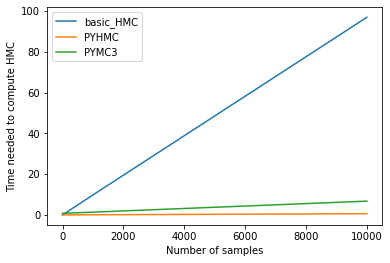

In [59]:
x = [10**t for t in range(t_max)]
ys = np.array(times_NoS)
plt.plot(x,ys[:,0],label='basic_HMC')
plt.plot(x,ys[:,1],label='PYHMC')
plt.plot(x,ys[:,2],label='PYMC3')
plt.xlabel('Number of samples')
plt.ylabel('Time needed to compute HMC')
plt.legend()

In [7]:
N_params = 3
N_samples = 100000



start = time.time()
samples = hmc(logprob, x0=np.random.randn(N_params), args=(ivar,), n_samples=N_samples)
print('Time needed to compute HMC: '+ str(time.time()-start) + ' s')

NameError: name 'time' is not defined